In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.inspection import permutation_importance

sys.path.append("..")
import util

%matplotlib inline

## Load data

In [2]:
df = pd.read_pickle("../run/solo/df-loo.pkl")
df = df[df.onset == 'INC']

df['pstatinf'] = np.where(df.seizing, df.pszinf, 1. - df.pszinf)
df['pstatemu'] = np.where(df.seizing, df.pszemu, 1. - df.pszemu)
df['pstatemw'] = np.where(df.seizing, df.pszemw, 1. - df.pszemw)

In [3]:
df = df.drop(columns=['observed', 'ttru', 'rhat', 'neff', 'pez', 'cinf', 'firstseizing', 'pfirst', 'pszinf', 'pszemu', 'pszemw',
         'pdinf', 'pdemu', 'pdemw', 'pt10inf', 'pt10emu', 'pt10emw', 'pt20inf', 'pt20emu', 'pt20emw'])

In [4]:
# Add Engel score

with open("../data/surgeries.vep.json") as fh:
    surgeries = json.load(fh)['data']
    surgeries = {int(k[2:5]): v for k, v in surgeries.items()}
    
df['engel'] = 0

for sid, surgery in surgeries.items():
    engel = surgery['engel']
    df.loc[df.subject == f"id{sid:03d}", 'engel'] = engel
    
# One-hot encoding
df = pd.concat([df, pd.get_dummies(df['engel'], prefix='engel')], axis=1)
df = df.drop(columns=['engel_0'])

In [5]:
# Add connection strengths

df['w_obs'] = 0.
df['w_all'] = 0.

for i, (subject, rid) in df[['subject', 'rid']].drop_duplicates().iterrows():
    indata = util.io.rload(f"../run/solo/INC/vep/{subject}/input/r{rid:02d}_all.R")
    w = indata['w']
    
    reg_obs = np.concatenate([indata['reg_ns'], indata['reg_sz']]).astype(int)
    for region in df[(df.subject == subject) & (df.rid == rid)].region:
        mask = (df.subject == subject) & (df.rid == rid) & (df.region == region)
        df.loc[mask, 'w_obs'] = np.sum(w[region, reg_obs]) + np.sum(w[reg_obs, region])
        df.loc[mask, 'w_all'] = np.sum(w[region, :]) + np.sum(w[:, region])

In [6]:
# Add duration and generalized status
with open("../data/SeizureInfo.json") as fh:
    clindata = json.load(fh)

df['duration'] = np.nan
df['generalized'] = False

for szdata in clindata:
    mask = (df.subject == f"id{szdata['sid']:03d}") & (df.rid == szdata['rid'])
    df.loc[mask, 'duration'] = szdata['duration']
    df.loc[mask, 'generalized'] = szdata['generalized']

In [7]:
# Differences in features
df['pstat_iu'] = df.pstatinf - df.pstatemu
df['pstat_iw'] = df.pstatinf - df.pstatemw
df['pt05_iu'] = df.pt05inf - df.pt05emu
df['pt05_iw'] = df.pt05inf - df.pt05emw

In [8]:
# Patient-level data

dfp = pd.read_excel("../data/PatientInfo.xlsx", skipfooter=1)
dfp = dfp.drop(columns=["Gender", "Side", "Epilepsy type",
                        "Age at epilepsy onset (y)", "Epilepsy duration (y)"])
dfp = dfp.rename(columns={"Patient": "subject", "Epilepsy Type Group analysis": "epitype"})
dfp.subject = [f"id{sid:03d}" for sid in dfp.subject]

epitypes = {"Not analysed": 0, "Temporal": 1, "Frontal/Fronto-temporal": 2, 
           "Motor/Insulo-opercular": 3, "Posterior/Postero-temporal": 4}

In [9]:
df['epitype'] = 0
df['mri'] = 0

for i, row in dfp.iterrows():
    mask = (df.subject == row.subject)
    df.loc[mask, 'epitype'] = epitypes[row.epitype]
    if row.MRI != "Normal":
        df.loc[mask, 'mri'] = 1
        
df = pd.concat([df, pd.get_dummies(df['epitype'], prefix='epitype')], axis=1)
df = df.drop(columns=['epitype_0'])        

In [10]:
df

,onset,subject,rid,region,seizing,nobs,nsz,nns,fracsz,pstatinf,...,pstat_iu,pstat_iw,pt05_iu,pt05_iw,epitype,mri,epitype_1,epitype_2,epitype_3,epitype_4
2945,INC,id001,0,1,False,21,6,15,0.285714,0.881,...,0.181,-0.116620,NaN,NaN,1,0,1,0,0,0
2946,INC,id001,0,8,False,21,6,15,0.285714,0.617,...,-0.083,-0.351176,NaN,NaN,1,0,1,0,0,0
2947,INC,id001,0,10,False,21,6,15,0.285714,0.779,...,0.079,-0.211310,NaN,NaN,1,0,1,0,0,0
2948,INC,id001,0,18,False,21,6,15,0.285714,0.810,...,0.110,-0.189643,NaN,NaN,1,0,1,0,0,0
2949,INC,id001,0,30,False,21,6,15,0.285714,0.391,...,-0.309,-0.471535,NaN,NaN,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,INC,id049,0,118,True,24,24,0,1.000000,0.902,...,-0.098,-0.098000,0.001000,0.001000,3,1,0,0,1,0
5804,INC,id049,0,139,True,24,24,0,1.000000,0.873,...,-0.127,-0.127000,0.044870,0.681037,3,1,0,0,1,0
5805,INC,id049,0,143,True,24,24,0,1.000000,0.911,...,-0.089,-0.089000,-0.242304,0.009706,3,1,0,0,1,0
5806,INC,id049,0,153,True,24,24,0,1.000000,0.881,...,-0.119,-0.119000,0.135348,0.041709,3,1,0,0,1,0


## Feature importances

In [21]:
def get_feature_importances(df, predictors, variables, method, alpha=None):
    importances = np.zeros((len(variables), len(predictors)))
    
    if method == "GradientBoosting":
        regressor = GradientBoostingRegressor(n_estimators=50, random_state=0)
    elif method == "RandomForest":
        regressor = RandomForestRegressor(random_state=0)
    elif method == "Lasso":
        regressor = Lasso(alpha=alpha)
    elif method == "Linear":
        regressor = LinearRegression()    

    for i, variable in enumerate(variables):
        if variable[:4] == "pt05":
            dff = df[~df.pt05inf.isna()]
        else:
            dff = df            
    
        x = np.array([dff[p] for p in predictors]).T
        scaler = preprocessing.RobustScaler()
        x = scaler.fit_transform(x)    
        y = np.array(dff[variable])
        
        regressor.fit(x, y)
        
        r = permutation_importance(regressor, x, y, n_repeats=30, random_state=0)
        importances[i, :] = r.importances_mean

    return importances

In [22]:
predictors = ['seizing', 'w_all', 'w_obs',
              'fracsz', 'nobs', 'duration', 'generalized',
              'engel_1', 'engel_2', 'engel_3', 'engel_4',
              'epitype_1', 'epitype_2', 'epitype_3', 'epitype_4',
              'mri']

predictors_labels = ["Seizing", "Node strength (all)", "Node strength (obs.)",
                     "Fraction seizing", "Number of obs. nodes", "Duration", "Generalized",
                     "Engel I", "Engel II", "Engel III", "Engel IV",
                     "Epilepsy type: T", "Epilepsy type: F/F-T", "Epilepsy type: M/I-O", "Epilepsy type: P/P-T",
                     "MRI"]
predictor_levels = ['R', 'R', 'R', 'S', 'S', 'S', 'S', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']

variables = ['pstat_iu', 'pstat_iw', 'pt05_iu', 'pt05_iw']
variables_labels = ["State PA: Inf-Est", "State PA: Inf-wEst", "Onset PA: Inf-Est", "Onset PA: Inf-wEst"]

importances = get_feature_importances(df, predictors, variables, "GradientBoosting")

## Partial dependency plots

In [23]:
def pdp(ax, df, variable, feature, groups, bins, xlabel=None, yticks=None):
    nbins = len(bins) - 1
    xs = np.zeros((3, nbins))
    xn = np.zeros((3, nbins))
    
    df = df[~df[variable].isna()]
    
    binning = pd.cut(df[feature], bins=bins)
    for i, bn in enumerate(binning.dtype.categories):
        dff = df[binning == bn]
        
        if 's' in groups:
            dfs = dff[dff.seizing]
            xs[:, i] = np.percentile(dfs[variable], [10, 50, 90])
        if 'n' in groups:
            dfn = dff[~dff.seizing]
            xn[:, i] = np.percentile(dfn[variable], [10, 50, 90])
        
    cbins = (bins[1:]+bins[:-1])/2.
    plt.sca(ax)
    
    if 's' in groups:
        plt.plot(cbins, xs[1, :], '-', color='r', label="Seizing regions")
        plt.fill_between(cbins, xs[0, :], xs[2, :], color='r', alpha=0.2)
    if 'n' in groups:
        plt.plot(cbins, xn[1, :], '-', color='b', label="Non-seizing regions")
        plt.fill_between(cbins, xn[0, :], xn[2, :], color='b', alpha=0.2)
        
    plt.axhline(0., color='k', ls='--')
    plt.ylim(-0.6, 0.6)
    plt.xlim(bins[0], bins[-1])
    if xlabel:
        plt.xlabel(xlabel)
    if yticks is not None:
        plt.yticks(yticks)
    plt.xticks([0., 0.5, 1], ["0", "0.5", "1"])

## Main figure

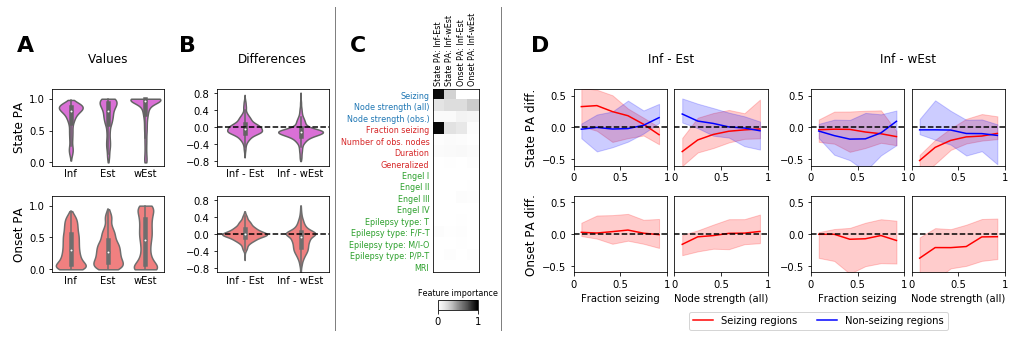

In [24]:
fig = plt.figure(figsize=(14, 4.5))

gs = GridSpec(3, 12, width_ratios=[0.4, 1.2, 0.4, 1.2, 0.7, 1, 0.6, 1, 1, 0.3, 1, 1], 
                       height_ratios=[0.0, 1, 1],
                       hspace=0.6, wspace=0.1,
                       left=0.00, right=0.99, bottom=0.18, top=0.84)


# Main results ---------------------------------------------------------------------- # 
util.plot.axtext(plt.subplot(gs[1, 0]), "State PA", fontsize=12, rotation='vertical', ha='right')
util.plot.axtext(plt.subplot(gs[2, 0]), "Onset PA", fontsize=12, rotation='vertical', ha='right')

util.plot.axtext(plt.subplot(gs[0, 1]), "Values",      fontsize=12, rotation='horizontal')
util.plot.axtext(plt.subplot(gs[0, 3]), "Differences", fontsize=12, rotation='horizontal')

pvars = ['pstat', 'pt05']
colors = {'all': 'orchid', 'seizing': 'lightcoral', 'nonseizing': 'lightskyblue'}
for i in range(len(pvars)):
    pvar = pvars[i]
    vinf = pvar + "inf"
    vemu = pvar + "emu"
    vemw = pvar + "emw"  
    color = colors['seizing'] if i == 1 else colors['all']
    
    ax = plt.subplot(gs[i+1, 1])
    sns.violinplot(data=[df[vinf], df[vemu], df[vemw]], cut=0., color=color, scale='area', saturation=1)
    plt.ylim(-0.05, 1.15)
    plt.xticks(np.r_[:3], ["Inf", "Est", "wEst"])
    ax.tick_params(axis='x', length=0)
    
    ax = plt.subplot(gs[i+1, 3])
    sns.violinplot(data=[df[vinf] - df[vemu], df[vinf] - df[vemw]], cut=0., color=color, scale='area', saturation=1)
    plt.xticks(np.r_[:2], ["Inf - Est", "Inf - wEst"])
    plt.axhline(0, color='k', ls='--')
    plt.ylim(-0.9, 0.9)
    plt.xlim(-0.5, 1.5)
    plt.yticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.tick_params(axis='x', length=0)

    
# Feature importances --------------------------------------------------------------- # 
ax = plt.subplot(gs[1:3, 5])
im = plt.imshow(importances.T, cmap='Greys', vmin=0, vmax=1)
plt.yticks(np.r_[:len(predictors)], predictors_labels, fontsize=8)
plt.xticks(np.r_[:len(variables)], variables_labels, rotation='vertical', fontsize=8)

ax.xaxis.tick_top()
ax.tick_params(length=0)

predictor_colors = {'R': 'tab:blue', 'S': 'tab:red', 'P': 'tab:green'}
for ticklabel, predictor_level in zip(ax.get_yticklabels(), predictor_levels):
    ticklabel.set_color(predictor_colors[predictor_level])

cbaxes = fig.add_axes([0.427, 0.065, 0.04, 0.03]) 
cb = plt.colorbar(im, cax=cbaxes, orientation='horizontal')
cb.set_label("Feature importance", fontsize=8)
cb.ax.xaxis.set_label_position('top')


# Partial dependency plots  -------------------------------------------------------- #
pdp(plt.subplot(gs[1, 7]), df, 'pstat_iu', 'fracsz', 'sn', np.linspace(0, 1, 7))
pdp(plt.subplot(gs[1, 8]), df, 'pstat_iu', 'w_all',  'sn', np.linspace(0, 1, 7), yticks=[])
plt.legend(bbox_to_anchor=(0.1, -1.85), ncol=2, loc='upper left')

pdp(plt.subplot(gs[1, 10]), df, 'pstat_iw', 'fracsz', 'sn', np.linspace(0, 1, 7))
pdp(plt.subplot(gs[1, 11]), df, 'pstat_iw', 'w_all',  'sn', np.linspace(0, 1, 7), yticks=[])

pdp(plt.subplot(gs[2, 7]), df, 'pt05_iu', 'fracsz', 's', np.linspace(0, 1, 7), xlabel="Fraction seizing")
pdp(plt.subplot(gs[2, 8]), df, 'pt05_iu', 'w_all',  's', np.linspace(0, 1, 7), xlabel="Node strength (all)", yticks=[])

pdp(plt.subplot(gs[2, 10]), df, 'pt05_iw', 'fracsz', 's', np.linspace(0, 1, 7), xlabel="Fraction seizing")
pdp(plt.subplot(gs[2, 11]), df, 'pt05_iw', 'w_all',  's', np.linspace(0, 1, 7), xlabel="Node strength (all)", yticks=[])


util.plot.axtext(plt.subplot(gs[1, 6]), "State PA diff.", fontsize=12, rotation='vertical', ha='right')
util.plot.axtext(plt.subplot(gs[2, 6]), "Onset PA diff.", fontsize=12, rotation='vertical', ha='right')
util.plot.axtext(plt.subplot(gs[0, 7:9]), "Inf - Est",   fontsize=12, rotation='horizontal')
util.plot.axtext(plt.subplot(gs[0, 10:12]), "Inf - wEst", fontsize=12, rotation='horizontal')
# ---------------------------------------------------------------------------------------# 

bg = util.plot.Background(visible=False)
bg.vline(0.325)
bg.vline(0.49)
bg.labels(xs=[0.01, 0.17, 0.34, 0.52], ys=[0.85, 0.85, 0.85, 0.85], fontsize=22)

plt.savefig("./img/loo.pdf")

In [686]:
# Number of data points
sum(~df.pstatinf.isna()), sum(~df.pt05inf.isna())

(2863, 1679)

In [14]:
len(df.subject.unique())

44

In [17]:
len(df[['subject', 'rid']].drop_duplicates())

137

In [18]:
len(df)

2863

## Feature importances with different methods

In [687]:
fi_gb = get_feature_importances(df, predictors, variables, "GradientBoosting")
fi_rf = get_feature_importances(df, predictors, variables, "RandomForest")
fi_lin = get_feature_importances(df, predictors, variables, "Linear")
fi_lasso = get_feature_importances(df, predictors, variables, "Lasso", alpha=0.01)

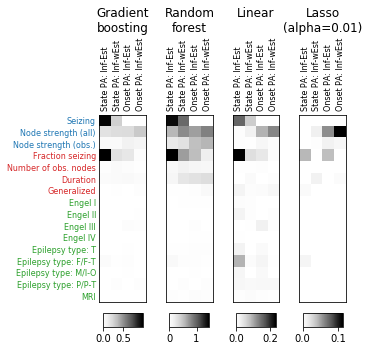

In [688]:
plt.figure(figsize=(5, 5))
gs = GridSpec(1, 4, wspace=0.0, left=0.24, right=0.98, bottom=0.00, top=0.65)

fis = [fi_gb, fi_rf, fi_lin, fi_lasso]
labels = ["Gradient\nboosting", "Random\nforest", "Linear\n", "Lasso\n(alpha=0.01)"]

for i, (fi, label) in enumerate(zip(fis, labels)):
    ax = plt.subplot(gs[0, i])
    plt.title(label)
    
    plt.imshow(fi.T, cmap='Greys')
    plt.colorbar(orientation='horizontal', shrink=0.6, pad=0.05, aspect=3)
    
    plt.xticks(np.r_[:len(variables)], variables_labels, rotation='vertical', fontsize=8)
    ax.xaxis.tick_top()
    ax.tick_params(length=0)

    if i == 0:
        plt.yticks(np.r_[:len(predictors)], predictors_labels, fontsize=8)

        predictor_colors = {'R': 'tab:blue', 'S': 'tab:red', 'P': 'tab:green'}
        for ticklabel, predictor_level in zip(ax.get_yticklabels(), predictor_levels):
            ticklabel.set_color(predictor_colors[predictor_level])
    else:
        plt.yticks([])
        
plt.savefig("./img/feature-importances.pdf")